In [30]:
import os
import sys
import numpy as np
import re
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pickle
from torch.nn.utils.rnn import pad_sequence
from unicodedata import normalize
from keras.preprocessing.text import Tokenizer
import keras
from torchvision import transforms, datasets
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pylab as pl
import matplotlib.pyplot as plt

In [31]:
#Lista com todos os arquivos necessarios para rodar esse código

# /scratch/joao.pedrosa/text_classification/
# /scratch/joao.pedrosa/text_classification/code/light_data/gold_standard.csv
# /scratch/joao.pedrosa/text_classification/code/light_data/gold_labels.npy
# /scratch/joao.pedrosa/text_classification/code/light_data/new_classes.npy
# /scratch/joao.pedrosa/text_classification/code/light_data/pytorch_tokenizer_10000.pickle
# /scratch/joao.pedrosa/text_classification/data/trained_models/pytorch_checkpoint_3.pth
# /scratch/joao.pedrosa/text_classification//data/resultados/scores/allLabels.npy
# /scratch/joao.pedrosa/text_classification/code/light_data/greenZoneIndex.npy
# /scratch/joao.pedrosa/text_classification/data/newGreenZoneIds.npy

In [32]:
ordem_classes_antigo = ['área_eletricamente_inativa',
       'Bloqueio_de_ramo_direito', 'Bloqueio_de_ramo_esquerdo',
       'Bloqueio_de_ramo_direito_e_bloqueio_divisional_anterossuperior_do_ramo_esquerdo',
       'Bloqueio_intraventricular_inespecífico',
       'Sobrecarga_ventricular_esquerda_(critérios_de_Romhilt-Estes)',
       'Sobrecarga_ventricular_esquerda_(critérios_de_voltagem)',
       'Fibrilação_atrial', 'Flutter_atrial',
       'Bloqueio_atrioventricular_de_2°_grau_Mobitz_I',
       'Bloqueio_atrioventricular_de_2°_grau_Mobitz_II',
       'Bloqueio_atrioventricular_2:1', 'Bloqueio_atrioventricular_avançado',
       'Bloqueio_atrioventricular_total',
       'Pré-excitação_ventricular_tipo_Wolff-Parkinson-White',
       'Sistema_de_estimulação_cardíaca_normofuncionante',
       'Sistema_de_estimulação_cardíaca_com_disfunção',
       'Taquicardia_atrial_multifocal', 'Taquicardia_atrial',
       'Taquicardia_supraventricular', 'Corrente_de_lesão_subendocárdica',
       'Alterações_primárias_da_repolarização_ventricular',
       'Extrassístoles_supraventriculares', 'Extrassístoles_ventriculares',
       'Bradicardia_sinusal',
       'ECG_dentro_dos_limites_da_normalidade_para_idade_e_sexo',
       'Alterações_da_repolarização_ventricular_atribuídas_à_ação_digitálica',
       'Alterações_inespecíficas_da_repolarização_ventricular',
       'Alterações_secundárias_da_repolarização_ventricular',
       'Arritmia_sinusal',
       'Ausência_de_sinal_eletrocardiográfico_que_impede_a_análise',
       'Interferência_na_linha_de_base_que_não_impede_a_análise_do_ECG',
       'Ausência_de_sinal_eletrocardiográfico_que_não_impede_a_análise',
       'Traçado_com_qualidade_técnica_insuficiente',
       'Possível_inversão_de_posicionamento_de_eletrodos',
       'Baixa_voltagem_em_derivações_precordiais',
       'Baixa_voltagem_em_derivações_periféricas',
       'Bloqueio_atrioventricular_de_1°_grau',
       'Bloqueio_de_ramo_direito_e_bloqueio_divisional_posteroinferior_do_ramo_esquerdo',
       'Bloqueio_divisional_anterossuperior_do_ramo_esquerdo',
       'Bloqueio_divisional_posteroinferior_do_ramo_esquerdo',
       'Desvio_do_eixo_do_QRS_para_direita',
       'Desvio_do_eixo_do_QRS_para_esquerda',
       'Dissociação_atrioventricular_isorrítmica',
       'Distúrbio_de_condução_do_ramo_direito',
       'Distúrbio_de_condução_do_ramo_esquerdo', 'Intervalo_PR_curto',
       'Intervalo_QT_prolongado', 'Isquemia_subendocárdica',
       'Progressão_lenta_de_R_nas_derivações_precordiais', 'Pausa_sinusal',
       'Corrente_de_lesão_subepicárdica',
       'Corrente_de_lesão_subepicárdica_-_provável_infarto_agudo_do_miocárdio_com_supradesnivelamento_de_ST',
       'Repolarização_precoce', 'Ritmo_atrial_ectópico',
       'Ritmo_atrial_multifocal', 'Ritmo_idioventricular_acelerado',
       'Ritmo_juncional', 'Síndrome_de_Brugada', 'Sobrecarga_atrial_direita',
       'Sobrecarga_atrial_esquerda', 'Sobrecarga_biatrial',
       'Sobrecarga_biventricular', 'Sobrecarga_ventricular_direita',
       'Sobrecarga_ventricular_esquerda(_critérios_de_voltagem)',
       'Taquicardia_sinusal', 'Taquicardia_ventricular_não_sustentada',
       'Taquicardia_ventricular_sustentada',
       'Suspeita_de_Síndrome_de_Brugada_repetir_V1-V2_em_derivações_superiores',
       'Taquicardia_juncional', 'Batimento_de_escape_atrial',
       'Batimento_de_escape_supraventricular', 'Batimento_de_escape_juncional',
       'Batimento_de_escape_ventricular']

ordem_classes = ['área_eletricamente_inativa',
 'Bloqueio_de_ramo_direito',
 'Bloqueio_de_ramo_esquerdo',
 'Sobrecarga_ventricular_esquerda_(critérios_de_Romhilt-Estes)',
 'Fibrilação_atrial',
 'Flutter_atrial',
 'Bloqueio_atrioventricular_de_2°_grau_Mobitz_I',
 'Pré-excitação_ventricular_tipo_Wolff-Parkinson-White',
 'Sistema_de_estimulação_cardíaca_normofuncionante',
 'Taquicardia_atrial_multifocal',
 'Taquicardia_supraventricular',
 'Alterações_primárias_da_repolarização_ventricular',
 'Extrassístoles_supraventriculares',
 'Extrassístoles_ventriculares',
 'Bradicardia_sinusal',
 'ECG_dentro_dos_limites_da_normalidade_para_idade_e_sexo',
 'Alterações_inespecíficas_da_repolarização_ventricular',
 'Alterações_secundárias_da_repolarização_ventricular',
 'Arritmia_sinusal',
 'Ausência_de_sinal_eletrocardiográfico_que_impede_a_análise',
 'Possível_inversão_de_posicionamento_de_eletrodos',
 'Bloqueio_atrioventricular_de_1°_grau',
 'Bloqueio_divisional_anterossuperior_do_ramo_esquerdo',
 'Bloqueio_divisional_posteroinferior_do_ramo_esquerdo',
 'Desvio_do_eixo_do_QRS_para_direita',
 'Desvio_do_eixo_do_QRS_para_esquerda',
 'Distúrbio_de_condução_do_ramo_direito',
 'Distúrbio_de_condução_do_ramo_esquerdo',
 'Intervalo_PR_curto',
 'Intervalo_QT_prolongado',
 'Isquemia_subendocárdica',
 'Progressão_lenta_de_R_nas_derivações_precordiais',
 'Ritmo_atrial_ectópico',
 'Sobrecarga_atrial_esquerda',
 'Taquicardia_sinusal']

Calculating labels with the Neural Network

In [33]:
#Loading Data
gold         = pd.read_csv("../../light_data/gold_standard.csv")
labels       = np.load("../../light_data/gold_labels.npy")
valid   = np.load("../../light_data/new_classes.npy")[:,1]

In [7]:
#ids_achados   = pd.read_csv('../../greenZoneIds.csv', index_col = 0)
#resultLabels   = pd.read_csv('../../../data/resultLabels.csv')
#baseC = pd.read_csv("../../../data/DATA_LAUDOS_TEXTO_formato1", sep = ";")

In [34]:
# Global variables
REBUILD_DATA = False
BIDIRECTIONAL = True
TOP_WORDS = 10000
EPOCHS = 30
BATCH_SIZE = 256

In [35]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on a GPU :D")
else:
    device = torch.device("cpu")
    print("Running on a CPU :/")

Running on a GPU :D


In [36]:
# Oi, Derick
# To comentando como diálogo porque acho mais fácil explicar o código assim. Se o comentário estiver errado é pq essa é a parte que eu entendi errado.
class Net(nn.Module):
    def __init__(self, seq_size):
        
        print("Building NN...")
        embedding_dim = 128
        lstm_out_dim = 128
        num_embeddings = TOP_WORDS
        num_of_classes = 35
        
        super().__init__()
        #Camada de Embedding, o padding_idx é um argumento que eu descobri que é usada para falar para a camada que os números no fim de cada vetor são apenas lixo
        self.l1 = nn.Embedding(num_embeddings, embedding_dim, padding_idx = 0)
        #Eu não entendo muito bem o que essa camada faz. Pelo que eu entendi é algo probabilístico. Mas ela n altera o shape.
#         self.l2 = nn.Dropout(p=0.4)
        #A LSTM recebe os Embeddings e cospe o mesmo número de vetores que eu passei para ela. Não sei se eu deveria alterar o número de camadas da LSTM.
        #Se usar menos de 2 não dá pra colocar Dropout pq o Dropout é aplicado em todas as camadas menos na última.
        self.l3 = nn.LSTM(embedding_dim, lstm_out_dim, dropout = 0.2, num_layers = 2, bidirectional = BIDIRECTIONAL)
        #É o seguinte. Como as dimensões de entrada são estáticas, eu adicionei elas manualmente na camada linear para conseguir fazer o flatten.
        self.l4 = nn.Flatten()
        #Dimensao do vetor de entrada X dimensao da lstm
        self.l5 = nn.Linear(seq_size * lstm_out_dim * (2 if BIDIRECTIONAL else 1), num_of_classes)
        
    
    def forward(self, x):
        #Aqui eu só to passando o input pelas camadas mesmo
        x    = self.l1(x)
#         x    = self.l2(x)
        #A camada de LSTM retorna uma tupla, o vetor que eu quero é a primeira posição da tupla, por isso recebo assim.
        #Acho que a segunda camada da LSTM só é util ao passar de uma camada da LSTM para a outra.
        x, _ = self.l3(x)
        x    = self.l4(x)
        x    = self.l5(x)
        #Aqui eu aplico o softmax. Especifico o número de dimensões para ser um e tal. Não sei o que não está funcionando :c.
        x    = F.softmax(x, dim = 1)
            
        return x

In [37]:
def clean_text(x):
    if type(x) is str:
        pattern = r'[^a-zA-z0-9!.?,:\s]'
        x = normalize('NFKD', x).encode('ASCII', 'ignore').decode('ASCII')
        x = re.sub(pattern, '', x)
        return x
    else:
        return ""

In [38]:
def tokenize(text, tokenizer, fit = False):
    # Creating vocabulary
    if fit:
        tokenizer.fit_on_texts(text)
    # Vectorizing text
    X   = tokenizer.texts_to_sequences(text)
    return X

In [39]:
with open("../../light_data/pytorch_tokenizer_10000.pickle", 'rb') as handle:
    tokenizer = pickle.load(handle)

In [40]:
#Atribua aqui seu teste
text = gold["texto"]

In [41]:
seq_size    = 423
text        = [clean_text(i) for i in text]
test_X_temp = tokenize(text, tokenizer, fit = False)
test_X_temp = [torch.Tensor(i).type(torch.LongTensor) for i in test_X_temp]
test_X_temp = pad_sequence(test_X_temp, batch_first=True).type(torch.LongTensor)

test_X = []
if(len(test_X_temp[0]) < seq_size):
    for i in range(len(test_X_temp)):
        line = test_X_temp[i]
        for j in range(seq_size - len(line)):
            line = torch.cat((line, torch.Tensor([0]).type(torch.LongTensor)), 0)
        test_X.append(line)
else:
    test_X = [line[:seq_size] for line in test_X_temp]
    
test_X = torch.stack([i for i in test_X])

In [42]:
net = Net(seq_size)
net.load_state_dict(torch.load("../../../data/trained_models/pytorch_checkpoint_3.pth",  map_location=torch.device('cuda:0')))
net.eval()

Building NN...


Net(
  (l1): Embedding(10000, 128, padding_idx=0)
  (l3): LSTM(128, 128, num_layers=2, dropout=0.2, bidirectional=True)
  (l4): Flatten()
  (l5): Linear(in_features=108288, out_features=35, bias=True)
)

In [43]:
finalResult = torch.Tensor()
size = 64
for i in tqdm(range(0, test_X.size()[0], size)):
    with torch.no_grad():
        result      = net(test_X[i: min(i+size, test_X.size()[0])])
    finalResult = torch.cat((finalResult, result), 0)

100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


In [44]:
y_test = np.array(np.array([[int(row[i]) for i in range(len(row)) if valid[i]] for row in labels]))
y_score = np.array(finalResult)

In [45]:
n_class = 35
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(n_class):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

Recovering labels from String Distance:

In [ ]:
#Loading data

#This contains the scores for the first 2000000 registers of all the Database
resultLabels = np.load('../../../data/resultados/scores/allLabels.npy')
#This contains the index of the greenzone
greenZoneIdx = np.load('../../light_data/greenZoneIndex.npy')
#This contains the Ids of the greenzone
greenZoneIds = np.load("../../../data/newGreenZoneIds.npy")

In [ ]:
#I'll order the array, preserving the original index as a variable, so I can do Binary Search
greenZoneIds = [[greenZoneIds[i], i] for i in range(len(greenZoneIds))]
greenZoneIds = np.array(greenZoneIds)
greenZoneIds = greenZoneIds[np.argsort(greenZoneIds[:, 0])]

In [ ]:
#Code for recovering the correct labels in O(NlogN)
y_lev = []
z = 0
for idTarget in gold["id_exame"]:
    pos = np.searchsorted(greenZoneIds[:,0],idTarget)
    if (pos == len(greenZoneIds) or greenZoneIds[pos][0] != idTarget): y_lev.append([0 for i in range(35)])
    else: y_lev.append(resultLabels[greenZoneIdx[greenZoneIds[pos][1]]])
    # This ↑ can be a bit confuse and if I read this code in the future I think I won't understand so i'll try to explain it
    # When we use the Binary Search and get the index of the id, we get it relative to the GreenZone ids
    # It means that if we get index one, it is the first element of the greenzone elements, in order to discover
    # which index it has relative to all elements we do greenZoneIdx[greenZoneIds[pos][1]]
y_lev = np.array(y_lev)

Analysis part:

In [51]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def getMetrics(y_test, y_score, thresholds):
    
    # Let's transform the output of the neural network into a binary vector
    # Here we will also take into account the label of the String Distance
    y_bin = []
    for j in range(len(finalResult)):
        ans = []
        for i in range(n_class):
#             if y_label[j][i]: #Taking only the Lev into account
            if finalResult[j][i] > thresholds[i]: #Taking only the network into account
#             if finalResult[j][i] > thresholds[i] or y_label[j][i]: #Taking both into account
                ans.append(1)
            else:
                ans.append(0)
        y_bin.append(np.array(ans))
    y_bin = np.array(y_bin)
    
    #Then we calculate
    target_names = ["(" + ordem_classes_antigo[i] + ") Class" + str(i) for i in range(n_class)]
    precision = dict()
    recall = dict()
    f1 = dict()
    sup = dict()
    for i in range(n_class):
        precision[i], recall[i], f1[i], sup[i] = precision_recall_fscore_support(y_test[:,i], y_bin[:,i], average = 'binary')
    return precision, recall, f1, sup

In [47]:
#Calculate limits by maximizing F1
from sklearn.metrics import precision_recall_fscore_support
limits = []
for j in range(n_class):
    print(j+1,"/",n_class)
    bigf1 = 0
    for threshold in thresholds[j]:
        y_bin = []
        for row in finalResult[:,j]:
            if row > threshold:
                y_bin.append(1)
            else:
                y_bin.append(0)
        y_bin = np.array(y_bin)
        precision, _, f1, _ = precision_recall_fscore_support(y_test[:,j], y_bin, average = 'binary')
        
        if(f1 > bigf1 and precision > 0):
            bigf1 = f1
            maxi = threshold
    limits.append(maxi)

1 / 35
2 / 35
3 / 35
4 / 35
5 / 35
6 / 35
7 / 35
8 / 35
9 / 35
10 / 35
11 / 35
12 / 35
13 / 35
14 / 35
15 / 35
16 / 35
17 / 35
18 / 35
19 / 35
20 / 35
21 / 35
22 / 35
23 / 35
24 / 35
25 / 35
26 / 35
27 / 35
28 / 35
29 / 35
30 / 35
31 / 35
32 / 35
33 / 35
34 / 35
35 / 35


In [59]:
#z = 0.1
#while(z < 1):
precision, recall, f1, _ = getMetrics(y_test, y_score, limits)
#   z += 0.1
f1 = sorted(f1.items(), key=lambda x: x[1], reverse=True)
df = pd.DataFrame(columns = ["Class", "Precision", "Recall", "F1", "Ocurrences"])
for row in f1:
    n = row[0]
    sup = y_test[:,n].sum()
    new_row = {'Class': str(ordem_classes[n]), 'Precision': precision[n], 'Recall': recall[n], 'F1': row[1], "Ocurrences": sup}
    df = df.append(new_row, ignore_index = True)
df = df.set_index("Class")

In [60]:
df

,Precision,Recall,F1,Ocurrences
Class,,,,
Ausência_de_sinal_eletrocardiográfico_que_impede_a_análise,1.000000,0.966667,0.983051,30
Flutter_atrial,0.971429,0.971429,0.971429,35
Arritmia_sinusal,0.918919,0.971429,0.944444,35
Sistema_de_estimulação_cardíaca_normofuncionante,0.964912,0.859375,0.909091,64
Intervalo_QT_prolongado,0.937500,0.882353,0.909091,34
Pré-excitação_ventricular_tipo_Wolff-Parkinson-White,0.878788,0.935484,0.906250,31
Ritmo_atrial_ectópico,0.852941,0.966667,0.906250,30
Bloqueio_de_ramo_esquerdo,0.892157,0.910000,0.900990,100
Fibrilação_atrial,0.831325,0.971831,0.896104,71


In [58]:
df.to_csv("../../../data/resultados/scores/results_nn_1.csv")

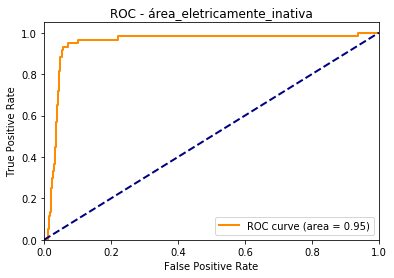

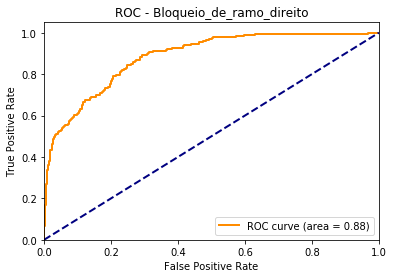

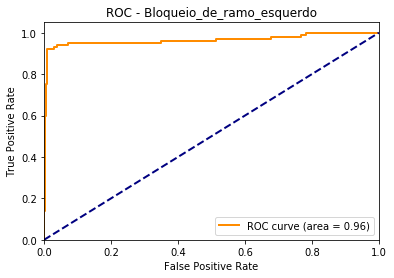

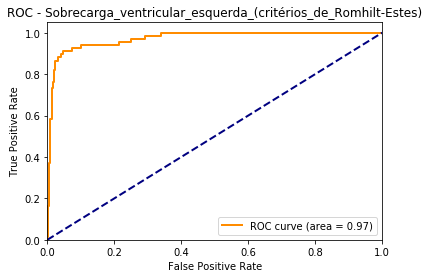

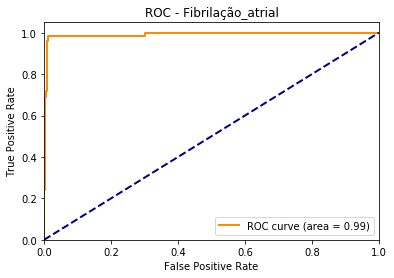

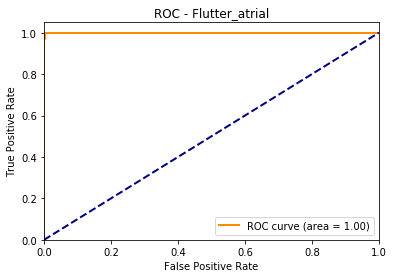

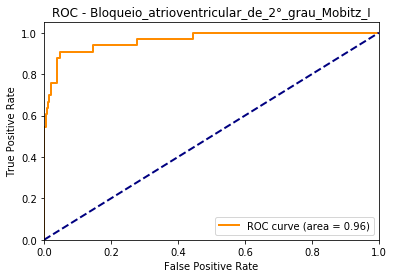

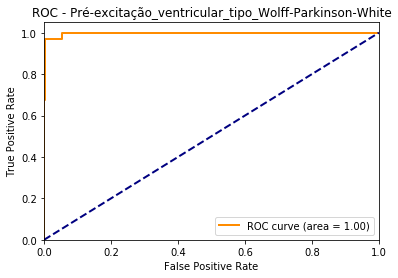

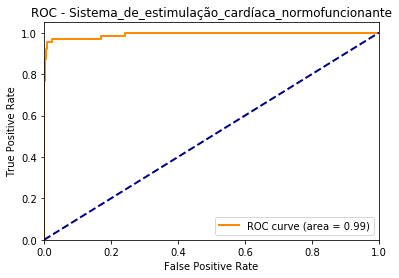

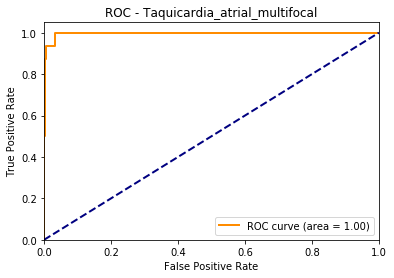

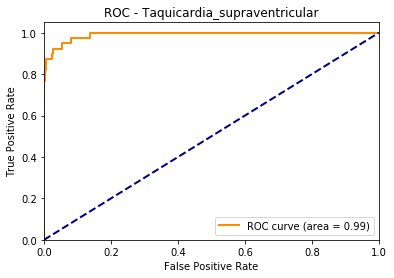

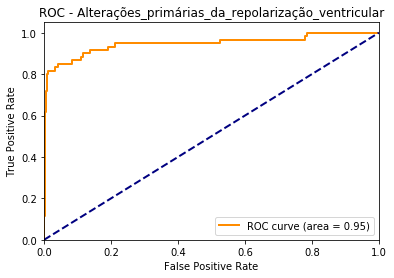

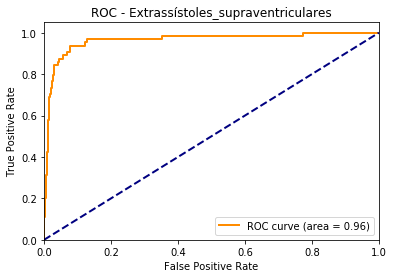

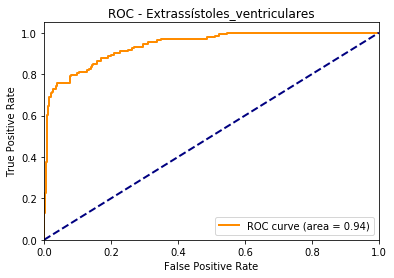

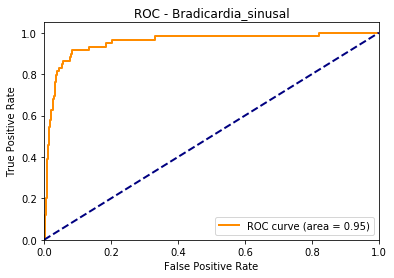

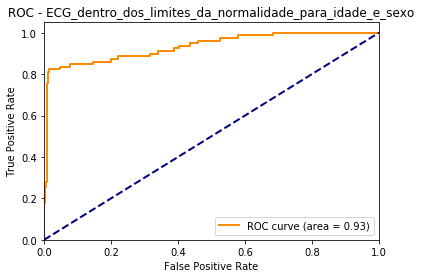

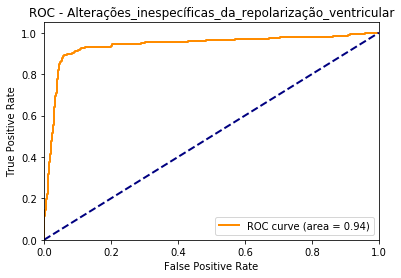

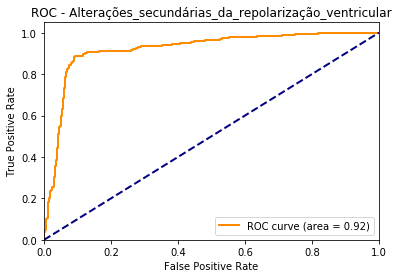

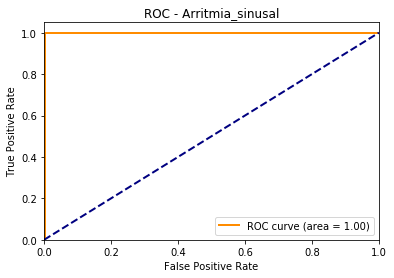

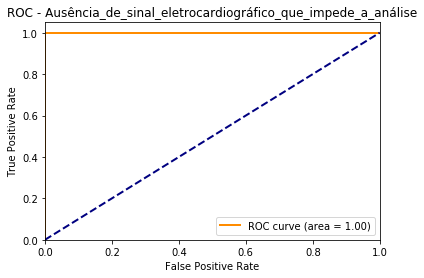

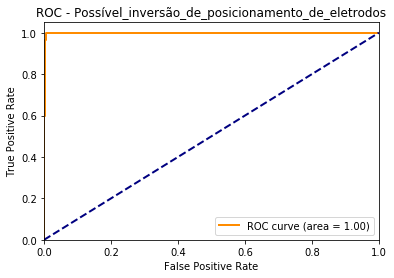

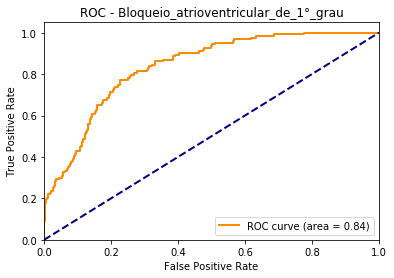

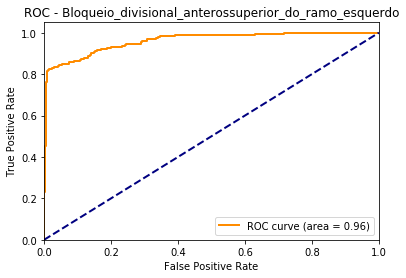

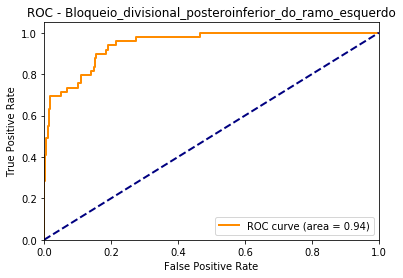

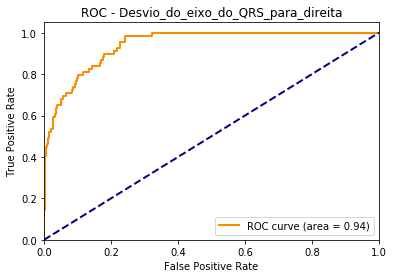

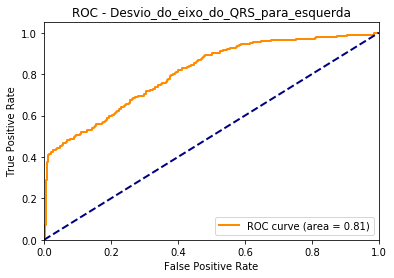

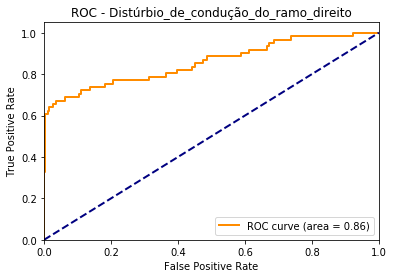

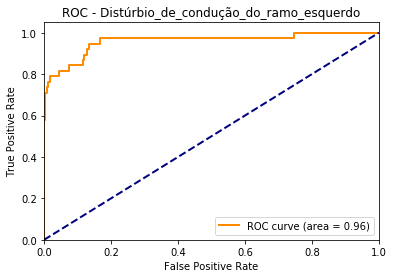

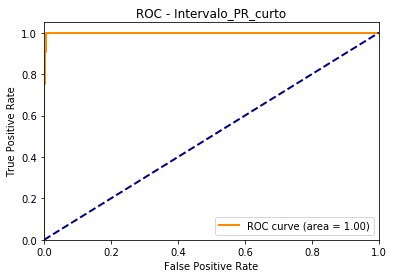

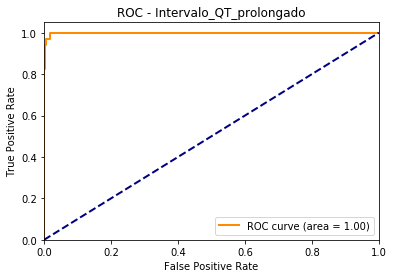

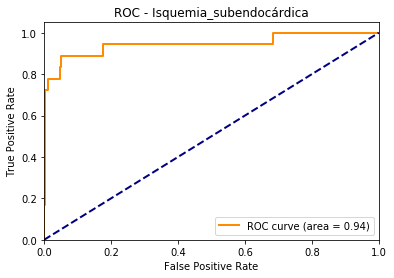

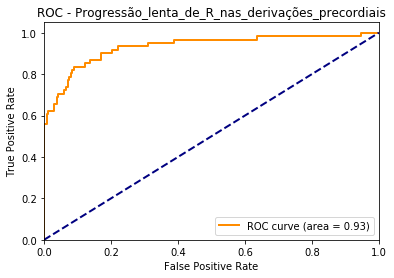

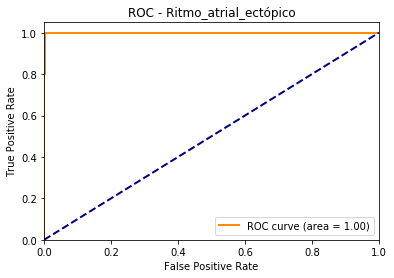

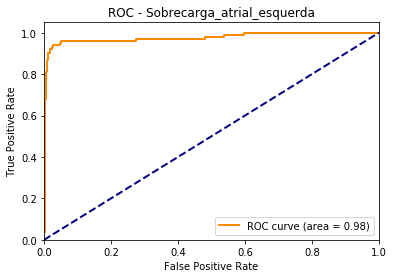

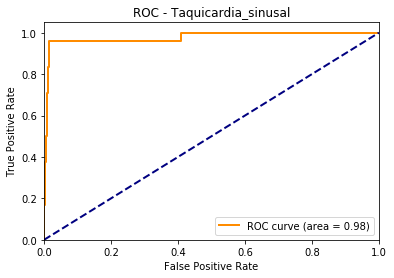

KeyError: 35

<Figure size 432x288 with 0 Axes>

In [62]:
#Code for plotting ROC curves
for i in range(74):
    nClass = i
    plt.figure()
    lw = 2
    plt.plot(fpr[nClass], tpr[nClass], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[nClass])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - ' + ordem_classes[nClass])
    plt.legend(loc="lower right")
    plt.savefig('../../test_data/testROC/nn_1/' + ordem_classes[nClass] + '.png')
    plt.show()

Calculating the maximum among all networks:

In [ ]:
r1  = pd.read_csv("../../../data/resultados/scores/results_nn_1.csv")
r2  = pd.read_csv("../../../data/resultados/scores/results_nn_2.csv")
r3  = pd.read_csv("../../../data/resultados/scores/results_nn_3.csv")
lev = pd.read_csv("../../../data/resultados/scores/results_levenshtein.csv")

In [ ]:
maximum = []
for diag in ordem_classes:
    a = r1[r1["Class"] == diag]["F1"]
    a = a.values[0]
    b = r2[r2["Class"] == diag]["F1"]
    b = b.values[0]
    c = r3[r3["Class"] == diag]["F1"]
    c = c.values[0]
    
    if(max([a,b,c]) == a): maxR = r1
    if(max([a,b,c]) == b): maxR = r2
    if(max([a,b,c]) == c): maxR = r3
    
    maxR = maxR[maxR["Class"] == diag]
    levA = lev[lev["Class"] == diag]
    p   = maxR["Precision"].values[0]
    r   = maxR["Recall"].values[0]
    f1  = maxR["F1"].values[0]
    oc  = r2[r2["Class"] == diag]["Ocurrences"].values[0]
    pl  = levA["Precision"].values[0]
    rl  = levA["Recall"].values[0]
    f1l = levA["F1"].values[0]
    
    
    maximum.append([diag,p,r,f1,oc, pl, rl, f1l])

In [ ]:
#Ordering by F1
maximum = np.array(maximum)
maximum = maximum[np.argsort(maximum[:, 3])]
maximum = np.flipud(maximum)

In [ ]:
df = pd.DataFrame(columns = ["Class", "Precision",  "LevPrecision", "Recall", "LevRecall", "Max F1", "LevF1", "Ocurrences"])
for row in maximum:
    new_row = {'Class': row[0], 'Precision': row[1],  "LevPrecision": row[5], 'Recall': row[2], "LevRecall": row[6],\
               'Max F1': row[3], "LevF1": row[7], "Ocurrences": row[4]}
    df = df.append(new_row, ignore_index = True)
df = df.set_index("Class")

In [ ]:
df.to_csv("../../../data/resultados/scores/results_nn_max_with_lev.csv")